<a href="https://colab.research.google.com/github/Zardian18/Celeb-Faces-Comparision/blob/master/VQ_VAE_faces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://raw.githubusercontent.com/Zardian18/helper-functions-colab/master/helper.py

--2024-02-27 10:09:29--  https://raw.githubusercontent.com/Zardian18/helper-functions-colab/master/helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17171 (17K) [text/plain]
Saving to: ‘helper.py’

helper.py           100%[===================>]  16.77K  --.-KB/s    in 0s      

2024-02-27 10:09:29 (125 MB/s) - ‘helper.py’ saved [17171/17171]



In [ ]:
!pip install kaggle

In [3]:
from google.colab import drive
drive.mount("/content/drive")

! mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

Mounted at /content/drive


In [4]:
! kaggle datasets download -d jessicali9530/celeba-dataset

100% 1.33G/1.33G [01:03<00:00, 16.5MB/s]
100% 1.33G/1.33G [01:03<00:00, 22.5MB/s]


In [ ]:
!unzip celeba-dataset.zip

In [6]:
!pip install -q tensorflow-probability

In [7]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
import tensorflow as tf
from helper import display, sample_batch

In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks, utils, metrics, losses, optimizers, activations
from helper import sample_batch, display
import pandas as pd
import numpy as np
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import tensorflow_probability as tfp

In [9]:
train_data = utils.image_dataset_from_directory(
    "/content/img_align_celeba",
    labels= None,
    color_mode= "rgb",
    image_size=(64,64),
    batch_size=32,
    shuffle = True,
    seed=42,
    interpolation= "bilinear"
)
train_data

Found 202599 files belonging to 1 classes.


<_PrefetchDataset element_spec=TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None)>

In [10]:
def preprocess(imgs):
  imgs = (tf.cast(imgs, "float32"))/255.0
  return imgs

train = train_data.map(lambda x: preprocess(x))

In [11]:
class VectorQuantizer(layers.Layer):
    def __init__(self, num_embeddings, embedding_dim, beta=0.25, **kwargs):
        super().__init__(**kwargs)
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings

        # The `beta` parameter is best kept between [0.25, 2] as per the paper.
        self.beta = beta

        # Initialize the embeddings which we will quantize.
        w_init = tf.random_uniform_initializer()
        self.embeddings = tf.Variable(
            initial_value=w_init(
                shape=(self.embedding_dim, self.num_embeddings), dtype="float32"
            ),
            trainable=True,
            name="embeddings_vqvae",
        )

    def call(self, x):
        # Calculate the input shape of the inputs and
        # then flatten the inputs keeping `embedding_dim` intact.
        input_shape = tf.shape(x)
        flattened = tf.reshape(x, [-1, self.embedding_dim])

        # Quantization.
        encoding_indices = self.get_code_indices(flattened)
        encodings = tf.one_hot(encoding_indices, self.num_embeddings)
        quantized = tf.matmul(encodings, self.embeddings, transpose_b=True)

        # Reshape the quantized values back to the original input shape
        quantized = tf.reshape(quantized, input_shape)

        # Calculate vector quantization loss and add that to the layer. You can learn more
        # about adding losses to different layers here:
        # https://keras.io/guides/making_new_layers_and_models_via_subclassing/. Check
        # the original paper to get a handle on the formulation of the loss function.
        commitment_loss = tf.reduce_mean((tf.stop_gradient(quantized) - x) ** 2)
        codebook_loss = tf.reduce_mean((quantized - tf.stop_gradient(x)) ** 2)
        self.add_loss(self.beta * commitment_loss + codebook_loss)

        # Straight-through estimator.
        quantized = x + tf.stop_gradient(quantized - x)
        return quantized

    def get_code_indices(self, flattened_inputs):
        # Calculate L2-normalized distance between the inputs and the codes.
        similarity = tf.matmul(flattened_inputs, self.embeddings)
        distances = (
            tf.reduce_sum(flattened_inputs ** 2, axis=1, keepdims=True)
            + tf.reduce_sum(self.embeddings ** 2, axis=0)
            - 2 * similarity
        )

        # Derive the indices for minimum distances.
        encoding_indices = tf.argmin(distances, axis=1)
        return encoding_indices

In [12]:
def get_encoder(latent_dim=128):
    encoder_inputs = keras.Input(shape=(64, 64, 3))
    x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(
        encoder_inputs
    )
    x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)

    x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)

    x = layers.Conv2D(256, 3, activation="relu", strides=2, padding="same")(x)

    encoder_outputs = layers.Conv2D(latent_dim, 1, padding="same")(x)
    return keras.Model(encoder_inputs, encoder_outputs, name="encoder")


def get_decoder(latent_dim=128):
    latent_inputs = keras.Input(shape=get_encoder(latent_dim).output.shape[1:])
    x = layers.Conv2DTranspose(256, 3, activation="relu", strides=2, padding="same")(
        latent_inputs
    )
    x = layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(x)

    x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)

    x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
    decoder_outputs = layers.Conv2DTranspose(3, 3, padding="same")(x)
    return keras.Model(latent_inputs, decoder_outputs, name="decoder")

In [13]:
def get_vqvae(latent_dim=128, num_embeddings=64):
    vq_layer = VectorQuantizer(num_embeddings, latent_dim, name="vector_quantizer")
    encoder = get_encoder(latent_dim)
    decoder = get_decoder(latent_dim)
    inputs = keras.Input(shape=(64, 64, 3))
    encoder_outputs = encoder(inputs)
    quantized_latents = vq_layer(encoder_outputs)
    reconstructions = decoder(quantized_latents)
    return keras.Model(inputs, reconstructions, name="vq_vae")


get_vqvae().summary()

Model: "vq_vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 encoder (Functional)        (None, 4, 4, 16)          392528    
                                                                 
 vector_quantizer (VectorQu  (None, 4, 4, 16)          1024      
 antizer)                                                        
                                                                 
 decoder (Functional)        (None, 64, 64, 3)         425283    
                                                                 
Total params: 818835 (3.12 MB)
Trainable params: 818835 (3.12 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [14]:
class VQVAETrainer(keras.models.Model):
    def __init__(self, train_variance, latent_dim=128, num_embeddings=128, **kwargs):
        super().__init__(**kwargs)
        self.train_variance = train_variance
        self.latent_dim = latent_dim
        self.num_embeddings = num_embeddings

        self.vqvae = get_vqvae(self.latent_dim, self.num_embeddings)

        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.vq_loss_tracker = keras.metrics.Mean(name="vq_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.vq_loss_tracker,
        ]

    def train_step(self, x):
        with tf.GradientTape() as tape:
            # Outputs from the VQ-VAE.
            reconstructions = self.vqvae(x)

            # Calculate the losses.
            reconstruction_loss = (
                tf.reduce_mean((x - reconstructions) ** 2) / self.train_variance
            )
            total_loss = reconstruction_loss + sum(self.vqvae.losses)

        # Backpropagation.
        grads = tape.gradient(total_loss, self.vqvae.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.vqvae.trainable_variables))

        # Loss tracking.
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.vq_loss_tracker.update_state(sum(self.vqvae.losses))

        # Log results.
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "vqvae_loss": self.vq_loss_tracker.result(),
        }

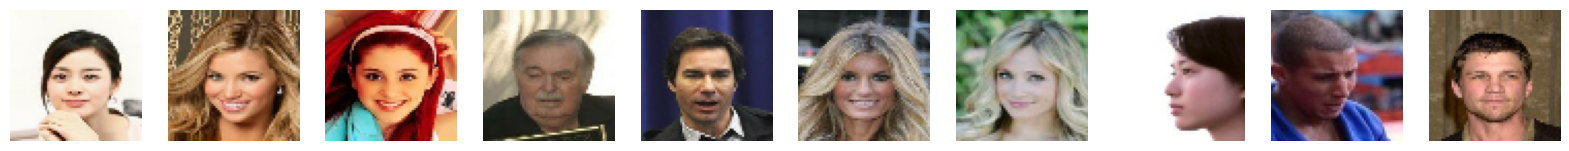

In [15]:
display(sample_batch(train))

In [16]:
train

<_MapDataset element_spec=TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None)>

In [ ]:
# def map_function(x):
#     # Replace this with your own mapping function
#     return x * 2

# mapped_dataset = train.map(map_function)

# mean = tf.reduce_mean(tf.concat(list(mapped_dataset), axis=0), axis=0)

# # Calculate the squared differences from the mean
# squared_diff = tf.square(tf.concat(list(mapped_dataset), axis=0) - mean)

# # Calculate the variance
# variance = tf.reduce_mean(squared_diff)

# # Create a TensorFlow session and run the computation
# with tf.compat.v1.Session() as sess:  # Using tf.compat.v1.Session for TensorFlow 2.x
#     variance_result = sess.run(variance)
#     print("Variance:", variance_result)

In [ ]:
# variance

In [19]:
vqvae_trainer = VQVAETrainer(0.5, latent_dim=128, num_embeddings=128)
vqvae_trainer.compile(optimizer=keras.optimizers.Adam())
vqvae_trainer.fit(train, epochs=30, batch_size=32)

Epoch 1/30
6332/6332 [==============================] - 190s 29ms/step - loss: 0.3701 - reconstruction_loss: 0.0498 - vqvae_loss: 0.2982
Epoch 2/30
6332/6332 [==============================] - 132s 21ms/step - loss: 0.0794 - reconstruction_loss: 0.0395 - vqvae_loss: 0.0395
Epoch 3/30
6332/6332 [==============================] - 137s 22ms/step - loss: 0.0782 - reconstruction_loss: 0.0387 - vqvae_loss: 0.0394
Epoch 4/30
6332/6332 [==============================] - 113s 18ms/step - loss: 0.0773 - reconstruction_loss: 0.0381 - vqvae_loss: 0.0391
Epoch 5/30
6332/6332 [==============================] - 114s 18ms/step - loss: 0.0772 - reconstruction_loss: 0.0379 - vqvae_loss: 0.0393
Epoch 6/30
6332/6332 [==============================] - 116s 18ms/step - loss: 0.0768 - reconstruction_loss: 0.0376 - vqvae_loss: 0.0391
Epoch 7/30
6332/6332 [==============================] - 113s 18ms/step - loss: 0.0771 - reconstruction_loss: 0.0374 - vqvae_loss: 0.0396
Epoch 8/30
6332/6332 [===================

KeyboardInterrupt: 

In [20]:
batches_to_predict = 1
example_images = np.array(
    list(train.take(batches_to_predict).get_single_element())
)

1/1 [==============================] - 0s 46ms/step
Example Images


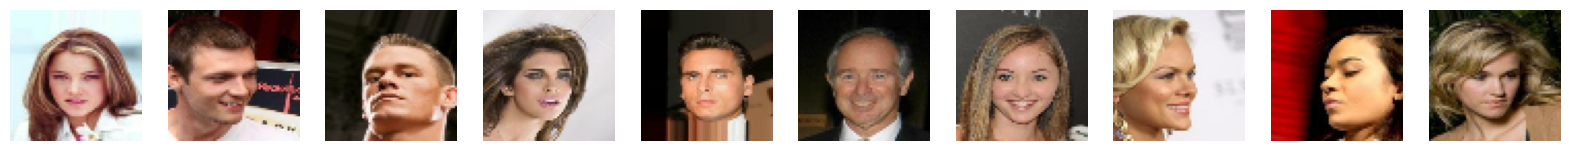

Recosntructed Images


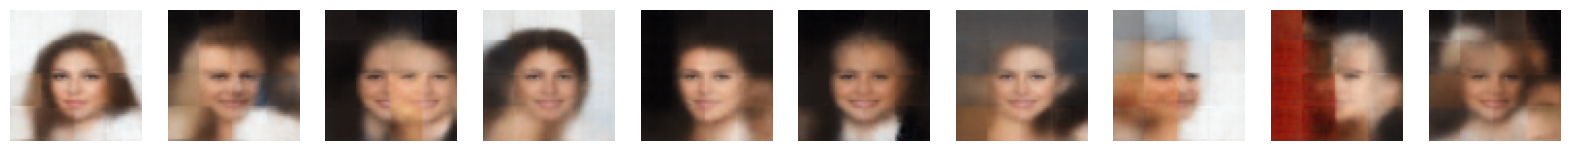

In [25]:
reconstructions = vqvae_trainer.vqvae.predict(example_images)
print("Example Images")
display(example_images)
print("Recosntructed Images")
display(reconstructions*255)

1/1 [==============================] - 0s 20ms/step
Example Images


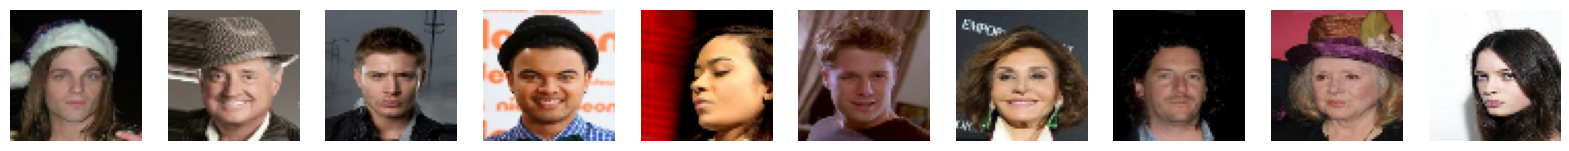

Recosntructed Images


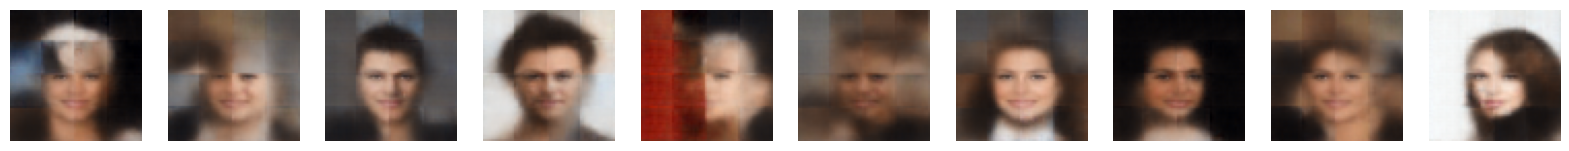

In [27]:
batches_to_predict = 1
example_images = np.array(
    list(train.take(batches_to_predict).get_single_element())
)
reconstructions = vqvae_trainer.vqvae.predict(example_images)
print("Example Images")
display(example_images)
print("Recosntructed Images")
display(reconstructions*255)

1/1 [==============================] - 0s 20ms/step
Example Images


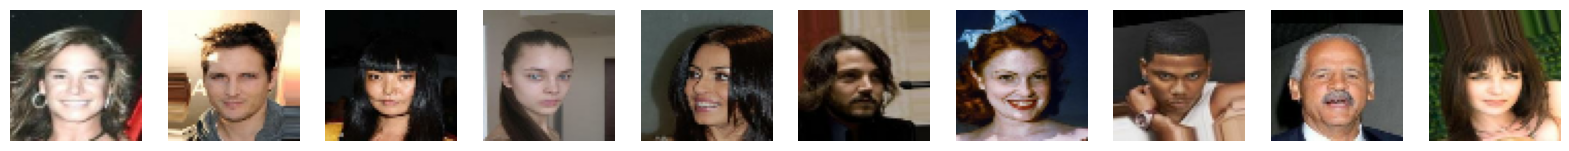

Recosntructed Images


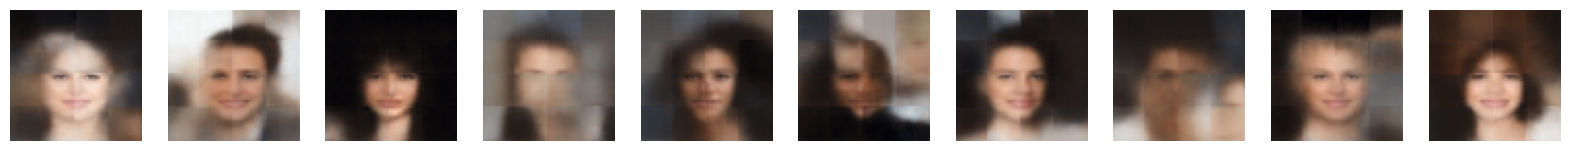

In [28]:
batches_to_predict = 1
example_images = np.array(
    list(train.take(batches_to_predict).get_single_element())
)
reconstructions = vqvae_trainer.vqvae.predict(example_images)
print("Example Images")
display(example_images)
print("Recosntructed Images")
display(reconstructions*255)

1/1 [==============================] - 0s 67ms/step
Example Images


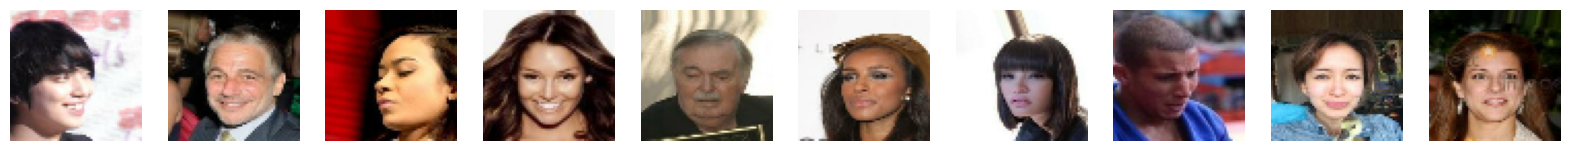

Recosntructed Images


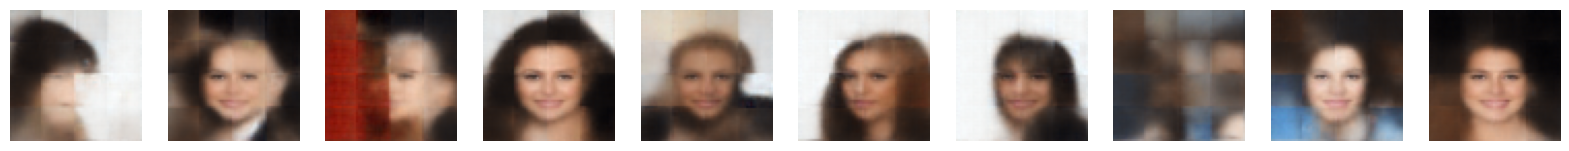

In [35]:
batches_to_predict = 1
example_images = np.array(
    list(train.take(batches_to_predict).get_single_element())
)
reconstructions = vqvae_trainer.vqvae.predict(example_images)
print("Example Images")
display(example_images)
print("Recosntructed Images")
display(reconstructions*255)

1/1 [==============================] - 0s 44ms/step
Example Images


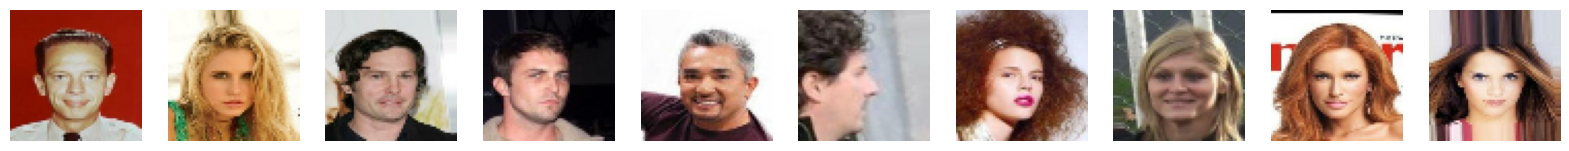

Recosntructed Images


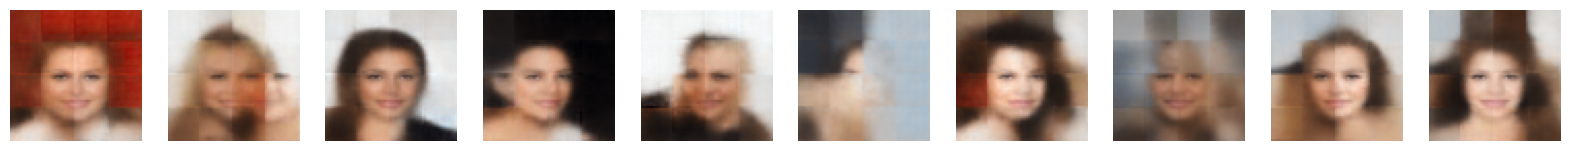

In [47]:
batches_to_predict = 1
example_images = np.array(
    list(train.take(batches_to_predict).get_single_element())
)
reconstructions = vqvae_trainer.vqvae.predict(example_images)
print("Example Images")
display(example_images)
print("Recosntructed Images")
display(reconstructions*255)

In [51]:
example_images.shape

(32, 64, 64, 3)

1/1 [==============================] - 0s 109ms/step


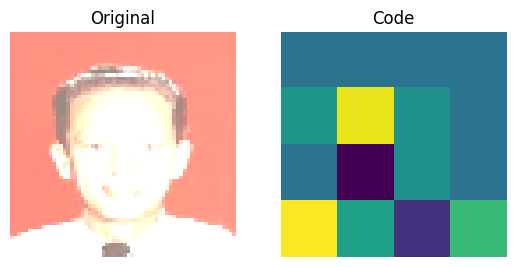

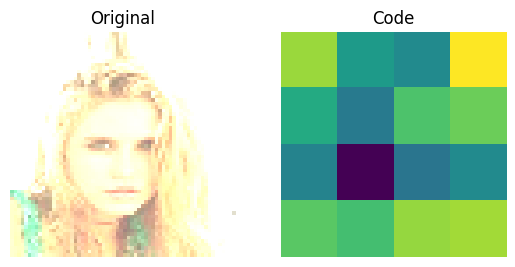

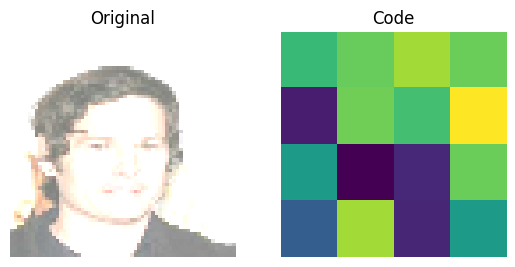

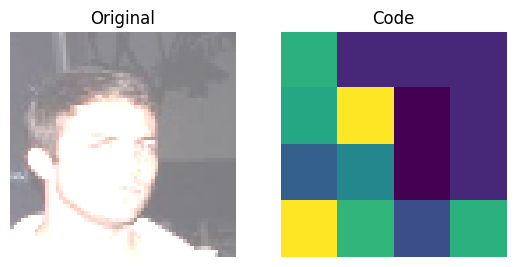

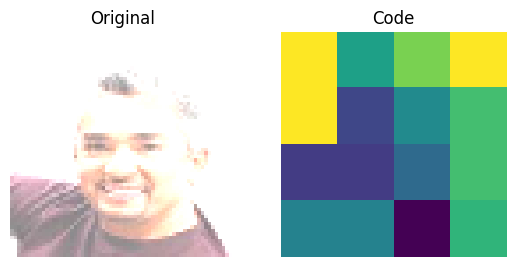

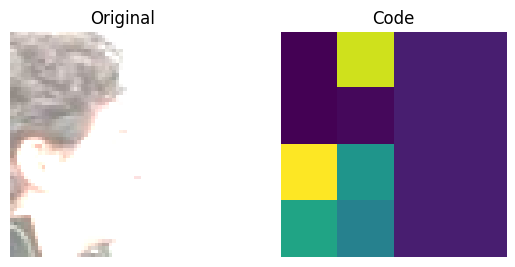

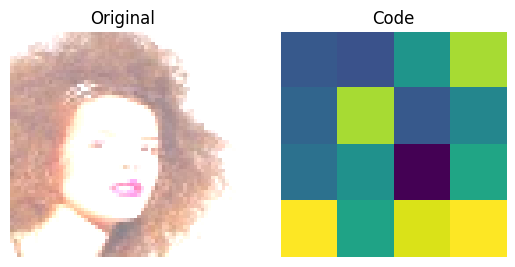

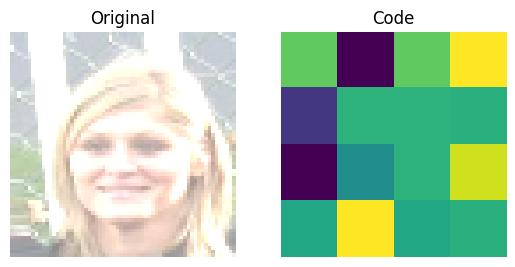

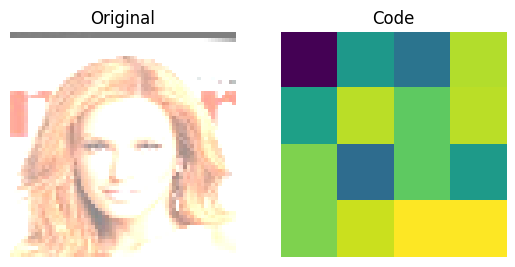

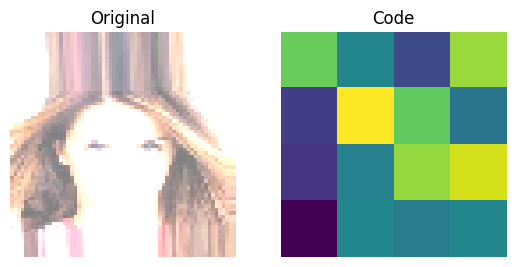

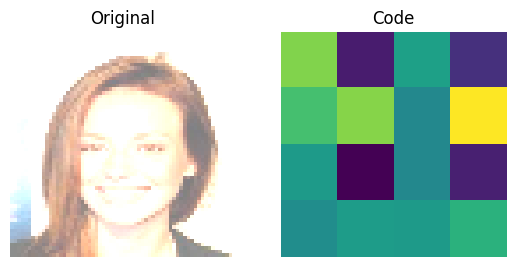

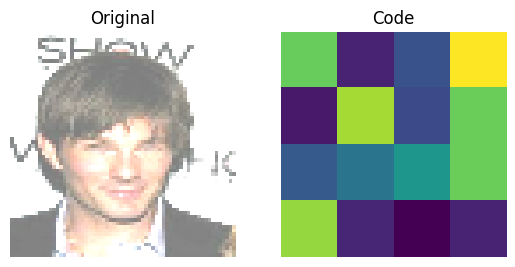

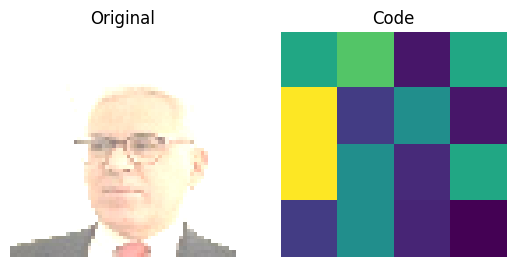

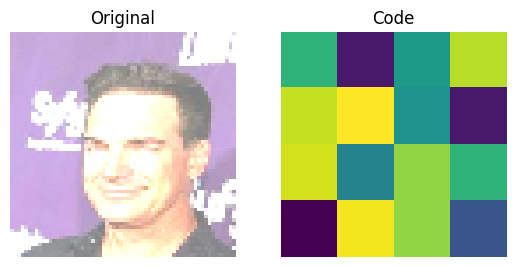

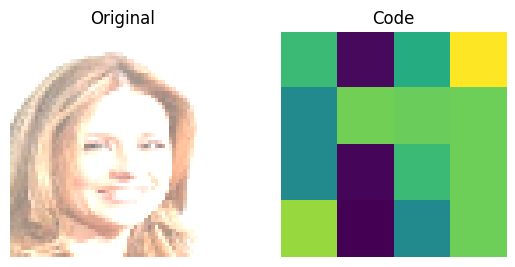

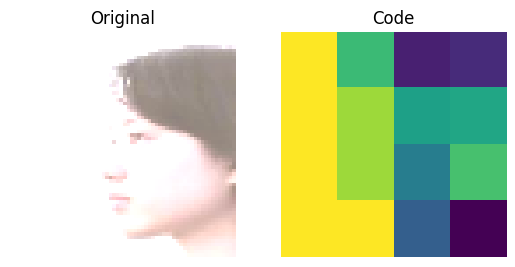

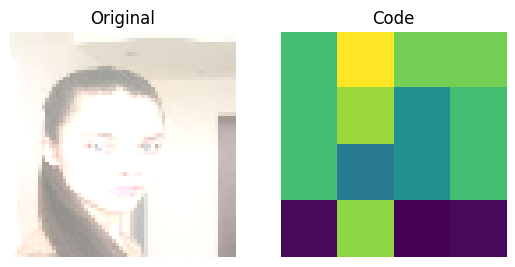

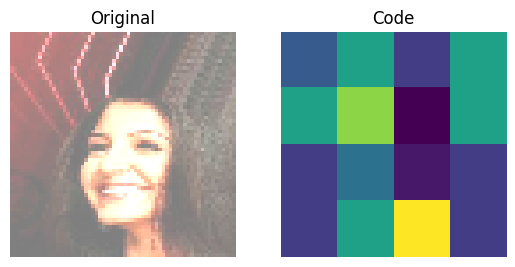

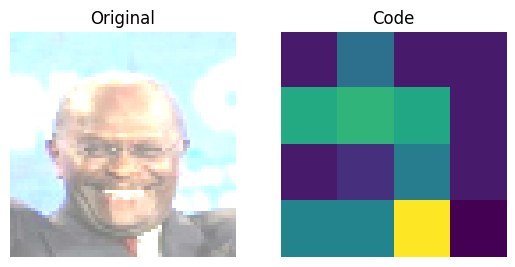

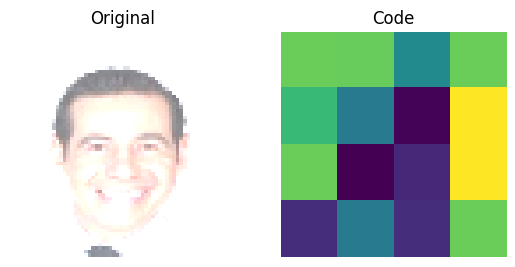

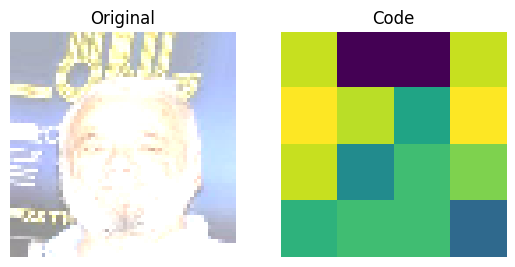

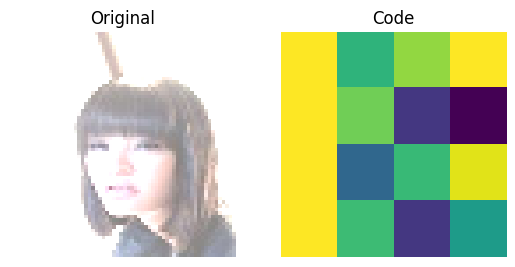

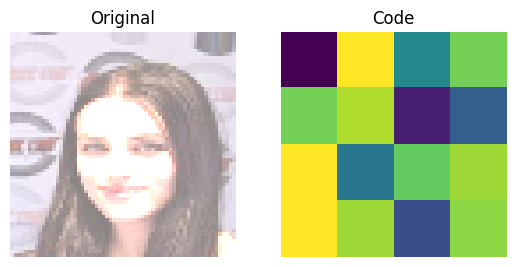

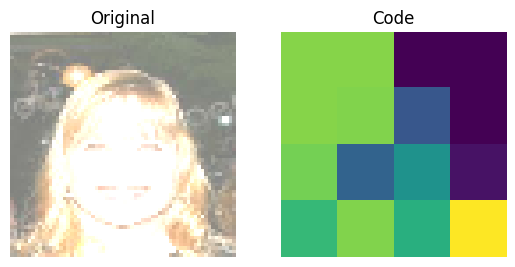

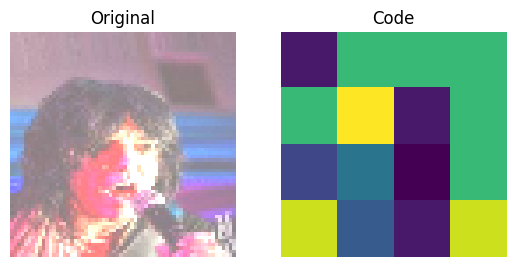

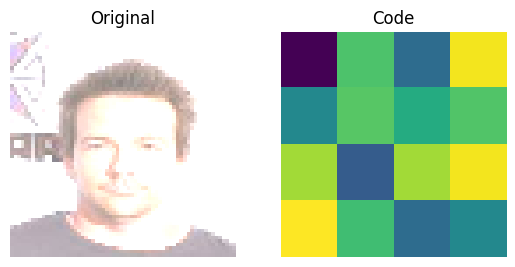

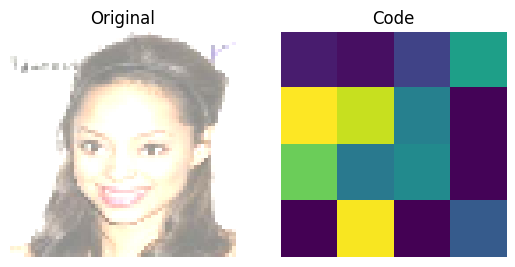

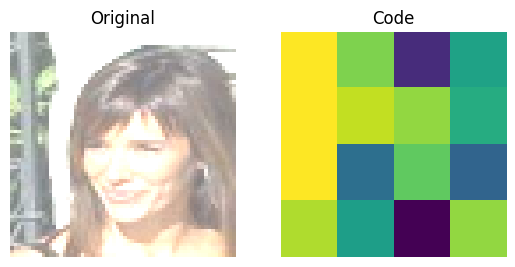

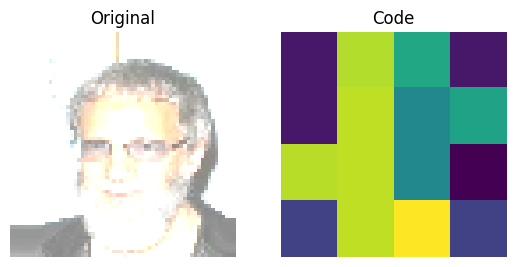

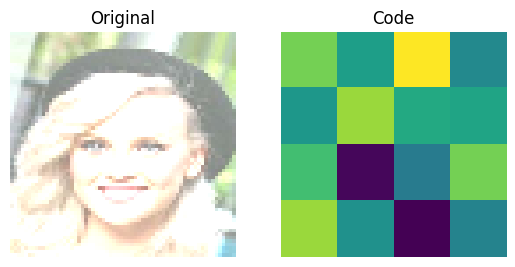

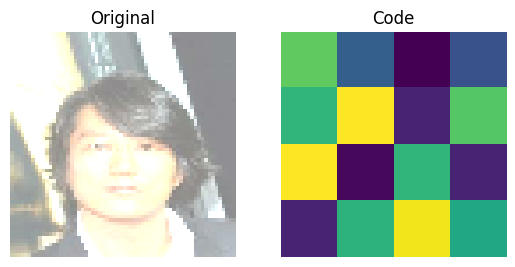

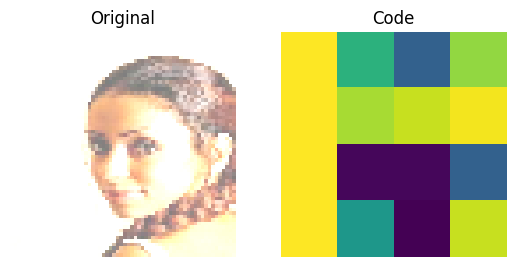

In [59]:
encoder = vqvae_trainer.vqvae.get_layer("encoder")
quantizer = vqvae_trainer.vqvae.get_layer("vector_quantizer")

encoded_outputs = encoder.predict(example_images)
flat_enc_outputs = encoded_outputs.reshape(-1, encoded_outputs.shape[-1])
codebook_indices = quantizer.get_code_indices(flat_enc_outputs)
codebook_indices = codebook_indices.numpy().reshape(encoded_outputs.shape[:-1])

for i in range(len(example_images)):
    plt.subplot(1, 2, 1)
    plt.imshow(example_images[i].squeeze() + 0.5)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(codebook_indices[i])
    plt.title("Code")
    plt.axis("off")
    plt.show()

In [60]:
decoder = vqvae_trainer.vqvae.get_layer("decoder")

In [ ]:
grid_width, grid_height = (10,3)
z_sample= np.random.normal(size=(grid_width*grid_height, 4,4,128)) # 10*3 new embeddings

reconstructions = decoder.predict(z_sample)

fig = plt.figure(figsize=(18,5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_width*grid_height):
  ax= fig.add_subplot(grid_height, grid_width, i+1)
  ax.axis(False)
  ax.imshow(reconstructions[i])